<a href="https://colab.research.google.com/github/jeremysb1/data_analysis_projects/blob/main/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metrics Project

The business has just been through its first winter sale. Stakeholders are interested in knowing which products performed best during the Christmas period so they can streamline the products they advertise in future sale periods.

I will do this by analyzing up to two months of events data, presented as two separate data sources with identical structures. Events refer not just to sales but to more general customer actions, such as viewing a product on the website or placing it into their virtual cart.

Some aspects they care about when ranking their products:

*  Volume of sales;
*  Total revenue from a single product;
*  Popularity measured by the number of unique customers who bought a product;
*  Conversion, meaning the percentage of time a product is bought once it has been placed in the virtual shopping cart; and
*  Products with increased performance from November to December.

The output of the analysis should be recommendations of the best-performing products on whichever dimension(s) I choose.

The recommendation could be for single product IDs or broader ones relating to brands or product categories, as long as your choice of “best” product is justified by my analysis.
`


A Minimum Viable Answer should contain:

- Measurements of our chosen metrics at a product level (e.g., a table of total revenue in December by product, sorted in descending revenue order)
- A ranking so we can highlight top performers
Justifications for which metrics were chosen
- A summary of our findings in tabular or visual form
- Recommendations for further iterations (if requested)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

november = pd.read_csv('/content/drive/MyDrive/Data Analysis Projects/Metrics/november.csv')
december = pd.read_csv('/content/drive/MyDrive/Data Analysis Projects/Metrics/december.csv')

events = pd.concat([november, december], axis=0, ignore_index=True)
print(events.shape)

(7033125, 9)


In [2]:
events.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code         0
brand            395108
price                 0
user_id               0
user_session         27
dtype: int64

In [3]:
events["event_time"] = pd.to_datetime(events["event_time"], format="%Y-%m-%d %H:%M:%S %Z")
events["event_time"].agg(["min", "max"])

min   2019-11-01 00:00:14+00:00
max   2019-12-31 23:59:09+00:00
Name: event_time, dtype: datetime64[ns, UTC]

In [4]:
(
    events
    .assign(month=events["event_time"].dt.month,
            day=events["event_time"].dt.day)
    .groupby("month")
    ["day"]
    .nunique()
)

month
11    30
12    31
Name: day, dtype: int64

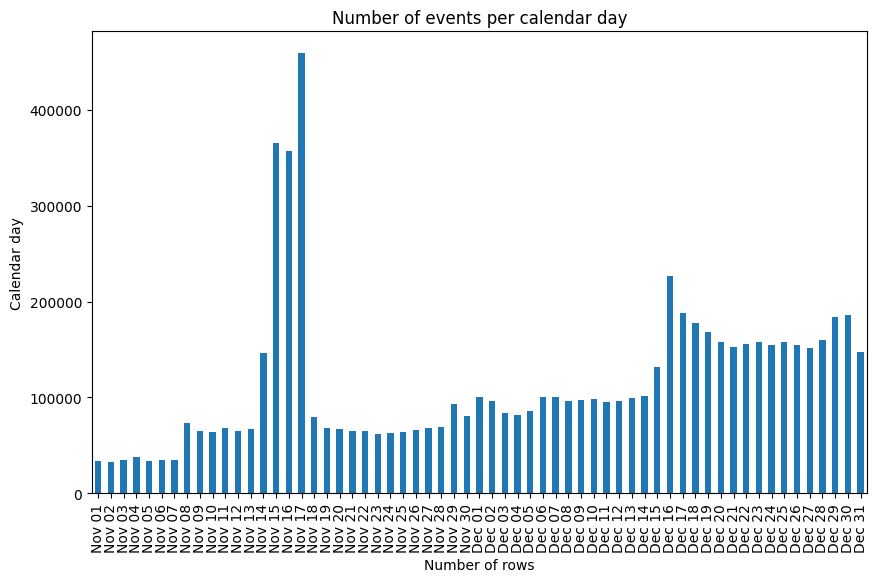

In [7]:
fig, axis = plt.subplots(figsize=(10, 6))

(
    events
    .assign(month=events["event_time"].dt.month, day=events["event_time"].dt.day)
    .groupby(["month", "day"])
    .size()
    .plot
    .bar(ax=axis)
)

labels = (
    pd.date_range(
        events["event_time"].dt.date.min(),
        events["event_time"].dt.date.max(),
        freq = "D")
    .strftime("%b %d")
)

axis.set(title="Number of events per calendar day",
         xlabel="Number of rows",
         ylabel="Calendar day",
         xticklabels=labels)

plt.show()